<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 5: Practical - Recurrent Neural Networks <br>
<font color=696880 size=4>
    Alireza Farashah, Parsa Hosseini
    
    
____


### Full Name : Arya Jalali
### Student Number : 98105665
___

# Image Captioning using Recurrent Neural Networks
In this notebook we want to implement a deep neural network to caption Flickr images. It has 8091 images and each image in this dataset has an ID and there are 5 caption for each image in captions.txt file which is uploaded in Quera. We use pretrained ResNet50 model to get meaningful features from each image. Code of this part is implemented and you have to use id_to_feature and id_to_caption dictionary. See the code to understand what are these two dictionaries.
You have to implement the empty parts of this notebook.

# Import Libaries and Dataset

In [22]:
import os
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Creeating Features and Captions Dcitionary

In [23]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

94765736/94765736 [==============================] - 0s 0us/step


In [24]:
import pickle 
id_to_features = pickle.load(open("features.pkl", "rb"))
id_to_features['587604325_af5d6df679'].shape

FileNotFoundError: ignored

In [25]:
from google.colab import drive
drive.mount('/content/drive')
import pickle 
id_to_features = pickle.load(open("drive/MyDrive/features.pkl", "rb"))
id_to_features['587604325_af5d6df679'].shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(1, 2048)

In [26]:
len(id_to_features)

8091

In [27]:
from itertools import islice

id_to_captions = {}

with open("captions.txt", 'r') as f:
    for i, line in enumerate(f):
        if i==0:
            continue
        tokens = line.split('.jpg,')
        id, caption = tokens[0], tokens[1]
        if id not in id_to_captions:
            id_to_captions[id] = []
        id_to_captions[id].append(caption) 
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

# Preprocessing and Tokenizing (15 points)

In [28]:
# preprocess caption texts
def preprocessing(mapping):
    for id, captions in mapping.items():
        for i, caption in enumerate(captions):
            # add start and end tokens
            caption = 'startseq ' + caption + ' endseq'
            caption = caption.replace('\t', '').replace('\ ' , '').replace('\n', '').lower()
            mapping[id][i] = caption
    return mapping

id_to_captions = preprocessing(id_to_captions)


In [29]:
all_captions = []
for captions in id_to_captions.values():
    for caption in captions:
        all_captions.append(caption)

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in all_captions])
print('Vocabulary Size: %d' % vocab_size)
print('Description Length: %d' % max_length)

Vocabulary Size: 8496
Description Length: 40


In [31]:
# print 2 random captions
for i in range(2):
    print(all_captions[np.random.randint(0, len(all_captions))])
    

startseq a brown dog squats in a deep pile of snow . endseq
startseq a boy pushing another boy up a pole . endseq


## Data Generator (25 points)

In this part implement a data generator function to use during the training.
For each image and caption you have to create number of train samples in the following format.

caption: "start_char the man is playing football end_char"

sample 0: X="start_char", Y="the "

sample 1: X="start_char the", Y="man"

...

sample n: X="start_char the man is playing football", Y="end_char"

In [32]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y =list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n +=1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into X, Y pairs
                for i in range(1, len(seq)):
                    
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0



image_ids = list(id_to_captions.keys())
split=int(len(image_ids)*0.90)
train= image_ids[:split]
test=image_ids[split:]

## Model (20 points)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from keras.layers import Embedding, LSTM, Dense

# encoder model
# image feature layer
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2, initial_state=[fe2, fe2])


#decoder model
decoder2 = Dense(256, activation='relu')(se3)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

generator = data_generator(train, id_to_captions, id_to_features, tokenizer, max_length, vocab_size, 32)

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      2174976     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

# Train (10 points)

Train the model and plot loss for training data.

In [35]:
# train the model

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# define the checkpoint
filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

steps_per_epoch = len(train)//32

# fit the model
model.fit(generator, epochs=20, steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[checkpoint])

# load the model
model = tf.keras.models.load_model('model.h5')


# evaluate the model

In [36]:
# save the model
model.save('model.h5')

## Test (30)

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions. 
Show 3 of the images and predictied samples.

In [72]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",)
bert_model = AutoModel.from_pretrained("bert-base-uncased",output_hidden_states=True)


def get_embeddings(text,token_length):
    tokens=bert_tokenizer(text,max_length=token_length,padding='max_length',truncation=True)
    output=bert_model(torch.tensor(tokens.input_ids).unsqueeze(0), attention_mask=torch.tensor(tokens.attention_mask).unsqueeze(0)).hidden_states[-1]
    return torch.mean(output,axis=1).detach().numpy()

def calculate_similarity(text1,text2,token_length=20):
    text1_embedding = get_embeddings(text1,token_length)
    text2_embedding = get_embeddings(text2,token_length)
    return cosine_similarity(text1_embedding.reshape(1,-1),text2_embedding.reshape(1,-1))[0][0]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
# load the model
model = tf.keras.models.load_model('model.h5')

Predicted Caption: two dogs run through a field of green grass


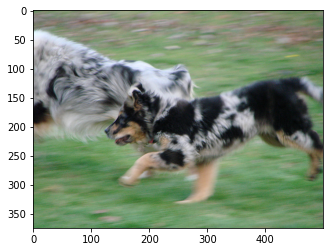

In [97]:
import matplotlib.pyplot as plt
#check model for 1 image
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

#check model for 1 image
image = '3094064787_aed1666fc9'
plt.imshow(plt.imread('images/Flicker8k_Dataset/' + image + '.jpg'))
image = id_to_features[image]
print("Predicted Caption:",predict_caption(image))

Average similarity score: 0.82


<Figure size 432x288 with 0 Axes>

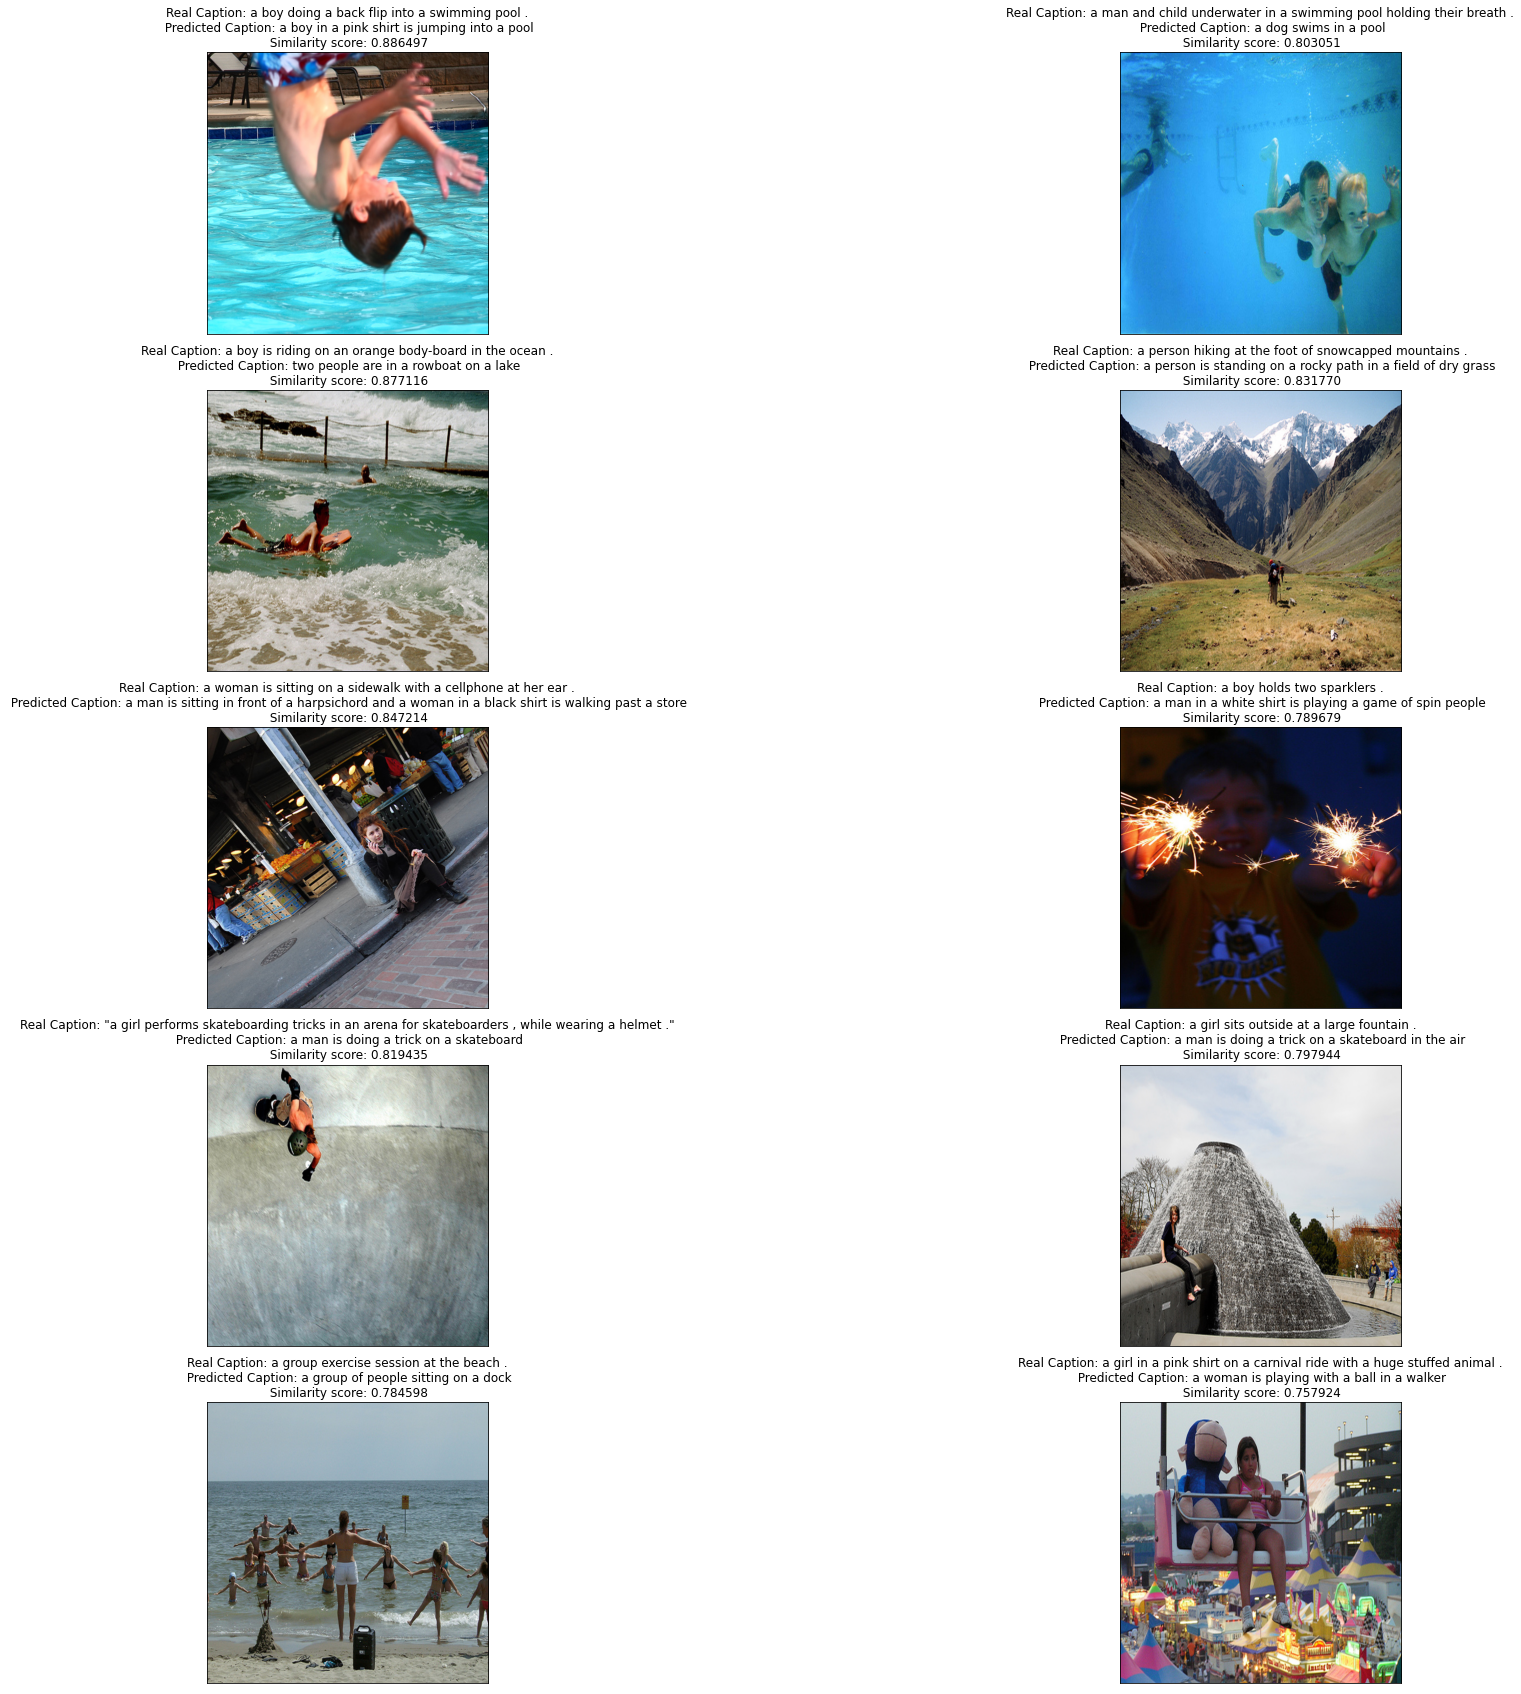

In [102]:
from PIL import Image
def plot_images():
  total = 0
  images = np.random.choice(test, size = 10, replace = False)
  captions = []
  for image in images:
    caption = id_to_captions[image][0]
    caption = caption.replace('startseq', '').replace('endseq', '')
    captions.append(caption[1:-1])

  plt.tight_layout()
  fig , axs = plt.subplots(5, 2, figsize=(30, 30), subplot_kw={'xticks': [], 'yticks': []})

  for img, caption, ax in zip(images, captions, axs.flatten()):
      path = 'images/Flicker8k_Dataset/' + img + '.jpg'
      predicted_caption = predict_caption(id_to_features[img])
      similarity_score = calculate_similarity(predicted_caption, caption, token_length = max_length)
      total += similarity_score
      img = Image.open(path)
      img = img.resize((512,512))
      ax.set_title(f'Real Caption: {caption}\n Predicted Caption: {predicted_caption}\n Similarity score: {similarity_score:2f}')
      ax.imshow(np.asarray(img))
  
  print(f'Average similarity score: {total / 10:.2f}')

plot_images()